<a href="https://colab.research.google.com/github/Krzesimir13/DataQuest/blob/main/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting heart desease by ML methods


---



##Project description

The project simulates working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

The dataset has the following features:

`Age`: age of the patient *[years]*

`Sex`: sex of the patient *[M: Male, F: Female]*

`ChestPainType`: chest pain type *[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]*

`RestingBP`: resting blood pressure *[mm Hg]*

`Cholesterol`: serum cholesterol *[mm/dl]*

`FastingBS`: fasting blood sugar *[1: if FastingBS > 120 mg/dl, 0: otherwise]*

`RestingECG`: resting electrocardiogram results *[Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]*

`MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]

`ExerciseAngina`: exercise-induced angina *[Y: Yes, N: No]*

`Oldpeak`: oldpeak = ST *[Numeric value measured in depression]*

`ST_Slope`: the slope of the peak exercise ST segment *[Up: upsloping, Flat: flat, Down: downsloping]*

`HeartDisease`: output class *[1: heart disease, 0: Normal]*

##1. Preparing the environment and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [12]:
np.set_printoptions(precision=3, suppress=False)
pd.options.display.precision = 3

*Uploading the data from Kaggle*

In [2]:
!pip -q install kagglehub

In [3]:
import os
print("KAGGLE_API_TOKEN" in os.environ)

False


In [4]:
import kagglehub
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
os.listdir(path)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.


['heart.csv']

In [5]:
raw_data = pd.read_csv(os.path.join(path, 'heart.csv'))
heart = raw_data.copy()

##2. Preview on the dataset

In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [13]:
heart.describe(include=['int', 'float'])

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,53.511,132.397,198.800,0.233,136.809,0.887,0.553
std,9.433,18.514,109.384,0.423,25.460,1.067,0.497
min,28.000,0.000,0.000,0.000,60.000,-2.600,0.000
25%,47.000,120.000,173.250,0.000,120.000,0.000,0.000
50%,54.000,130.000,223.000,0.000,138.000,0.600,1.000
75%,60.000,140.000,267.000,0.000,156.000,1.500,1.000
max,77.000,200.000,603.000,1.000,202.000,6.200,1.000


Observations:

No missing values

Average age : 53.5

Some 0 values in `Cholesterol` and `RestingBP` - not measured?

In [19]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

heart[categorical_cols].value_counts()

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        109
     ATA            Normal      N               Up           64
     ASY            Normal      N               Flat         55
                    ST          Y               Flat         49
     NAP            Normal      N               Up           46
                                                           ... 
     TA             LVH         Y               Flat          1
                                                Up            1
                    Normal      Y               Up            1
                    ST          N               Down          1
                                Y               Flat          1
Name: count, Length: 95, dtype: int64

Unique values in categorical columns:

In [20]:
{col : heart[col].unique().tolist() for col in categorical_cols}

{'Sex': ['M', 'F'],
 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA'],
 'RestingECG': ['Normal', 'ST', 'LVH'],
 'ExerciseAngina': ['N', 'Y'],
 'ST_Slope': ['Up', 'Flat', 'Down']}

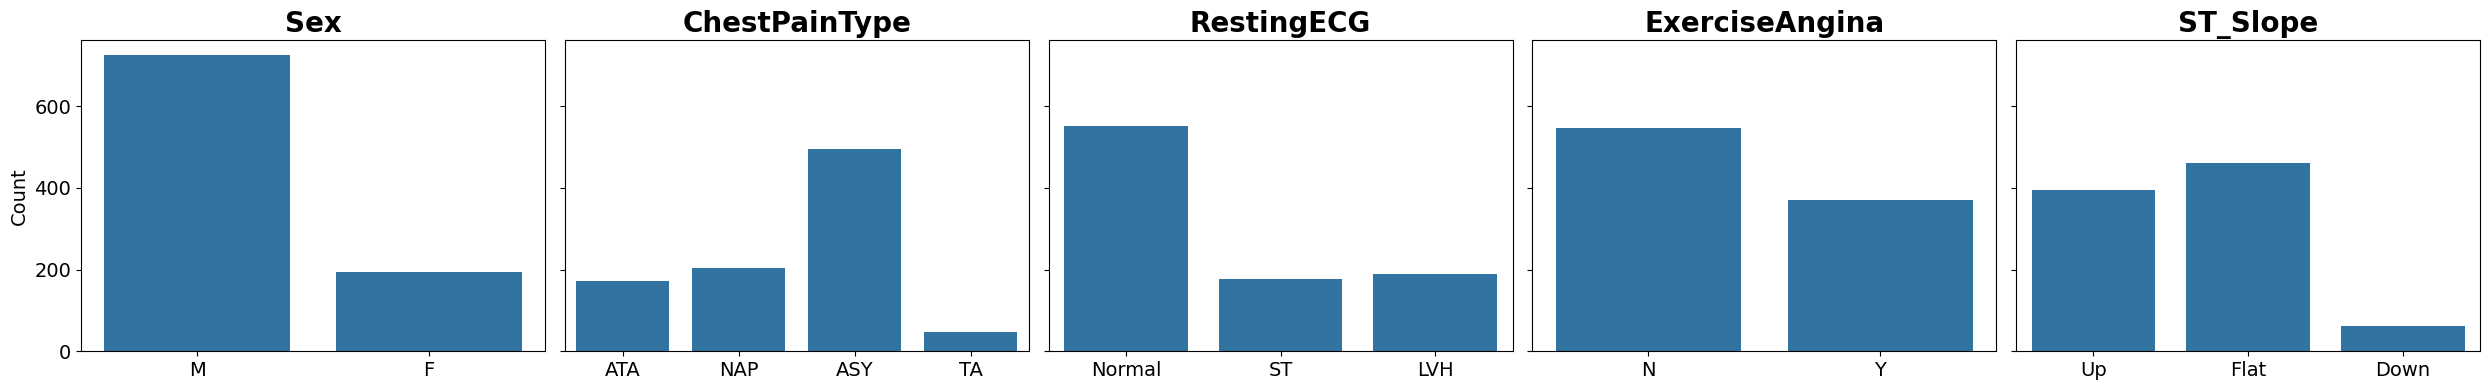

In [35]:
n_cols = len(categorical_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4), sharey=True)

for i, col in enumerate(categorical_cols):
  sns.countplot(x=col, data=heart, ax=axes[i])
  axes[i].set_title(col, fontsize=20, fontweight='bold')
  axes[i].set_xlabel('')
  axes[i].tick_params(axis='both', labelsize=14)
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [37]:
for col in categorical_cols:
    fig = px.histogram(heart, x=col, color="HeartDisease",
                       title=col,
                       barmode='stack', # To zapewnia układ jeden na drugim
                       color_discrete_map={'0': '#2ca02c', '1': '#d62728'},
                       text_auto=True) # Dodaje liczby na słupkach

    fig.update_layout(bargap=0.2, font=dict(size=18))
    fig.show()